## Import Modules

Scipy provides the *least_squares* optimization function

In [2]:
# Pandas and table
import pandas as pd
# Opimization
from scipy.optimize import least_squares
import numpy as np
# Plotting curve
import matplotlib.pylab as plt

## Definition of the model function used to fit the data
In the following example we will fit experimantal data with the ***Ogden model***

$\sigma_{\text{eng uniax}} = \displaystyle\sum_{p=1}^n 2\mu_{p} \left[\lambda^{(\alpha_{p}-1)} - \lambda^{-(1/2\alpha_{p}+1)}\right]$

For a 3rd order model, we have 6 parameters : $\mu_{1}, \alpha_{1}, \mu_{2}, \alpha_{2}, \mu_{3}, \alpha_{3}$

In [3]:
def OgdenModel(trueStrain, parameters, order):
    """Ogden hyperelastic model (incompressible material under uniaxial tension)
    Uses true strain and true stress data"""
                
    # parameter is a 1D array : [mu0,mu1,...,mun,alpha0,alpha1,...,alphan] 
    muVec = parameters.reshape(2, order)[0]
    alphaVec = parameters.reshape(2, order)[1]
    lambd = np.exp(trueStrain)
    # broadcasting method to speed up computation
    lambd = lambd[np.newaxis, :]
    muVec = muVec[:order, np.newaxis]
    alphaVec = alphaVec[:order, np.newaxis]
        
    trueStress = np.sum(2*muVec*(lambd**(alphaVec - 1) - lambd**(-((1/2)*alphaVec + 1))), axis=0)
    return trueStress

## Definition of the cost function

The aim of the optimisation algorithm is to minimize the Residual Sum of Squares

$\textit{Residual Sum of Squares} = \displaystyle\sum_{i=1}^n \left(\sigma_{model} - \sigma_{data}\right)^{2}$

In [4]:
# cost function to calculate the residuals. The fitting function holds the parameter values.  
def objectiveFun_Callback(parameters, exp_strain, exp_stress):  
    theo_stress = OgdenModel(exp_strain, parameters, order)   
    residuals = theo_stress - exp_stress 
    return residuals

## Read Experimental data

In [5]:
file = 'DragonSkin20.csv' # Replace space by %20 for html url 
header = pd.read_csv(file, delimiter = ';', usecols = ["PARAMETER", "INFO", "URL"]).head(15)
data = pd.read_csv(file, delimiter = ';',skiprows=18, names = ['Time (s)','True Strain','True Stress (MPa)','Engineering Strain','Engineering Stress (MPa)']) # the column headers are on line 16 from the top of the file

In [6]:
header

,PARAMETER,INFO,URL
0,Specimen Thickness (mm),3,NaN
1,Specimen Width (mm),6,NaN
2,Specimen Length (mm),33,NaN
3,Specimen Cross-section (cm^2),0.18,NaN
4,Standard,ASTM D412,NaN
5,Type of test,Pull-to-failure,NaN
6,Speed (mm/min),450,NaN
7,Machine,Instron 5569,NaN
8,Load Cell,1 kN - Instron 2525-806,NaN
9,Grippers,Instron 2710-010,NaN


In [7]:
data

,Time (s),True Strain,True Stress (MPa),Engineering Strain,Engineering Stress (MPa)
0,0.2,0.043637,0.009762,0.044600,0.009343
1,0.3,0.065743,0.019337,0.067950,0.018107
2,0.4,0.086950,0.028433,0.090843,0.026063
3,0.5,0.107613,0.036371,0.113620,0.032660
4,0.6,0.127830,0.044294,0.136360,0.038980
...,...,...,...,...,...
399,40.1,2.313885,44.406199,9.113635,4.390725
400,40.2,2.316130,44.617326,9.136365,4.401710
401,40.3,2.318370,44.835612,9.159090,4.413350
402,40.4,2.320600,45.047888,9.181820,4.424345


In [8]:
exp_strain = data['True Strain'].values        # .values converts panda series to numy array
exp_stress = data['True Stress (MPa)'].values

## Least square optimisation function

In [9]:
order = 3
initialGuessMu = np.array([0.1]*order)     # ["µ1","µ2","µ3"]
initialGuessAlpha = np.array([0.2]*order)  # ["α1","α2","α3"]
initialGuessParam = np.append(initialGuessMu,initialGuessAlpha)
nbparam = order*2
param_names = ["µ1","µ2","µ3","α1","α2","α3"]

In [10]:
# The least_squares package calls the Levenberg-Marquandt algorithm.
# best-fit paramters are kept within optim_result.x
optim_result = least_squares(objectiveFun_Callback, initialGuessParam, method ='lm', args=(exp_strain, exp_stress))
optim_parameters = optim_result.x
   
theo_stress = OgdenModel(exp_strain, optim_parameters, order)

## Results

In [11]:
print('optimised parameters:')
print('µ1=' + str(optim_parameters[0]))
print('µ2=' + str(optim_parameters[1]))
print('µ3=' + str(optim_parameters[2]))
print('α1=' + str(optim_parameters[3]))
print('α2=' + str(optim_parameters[4]))
print('α3=' + str(optim_parameters[5]))

optimised parameters:
µ1=0.007410965928874807
µ2=0.08212784341342322
µ3=0.011386289820264345
α1=3.336147096585031
α2=3.336174331775407
α3=3.336183246693289


(0.0, 2.0)

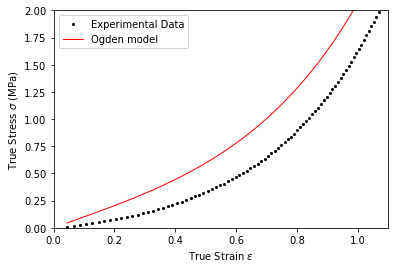

In [22]:
# Plotting the data
plt.plot(exp_strain,exp_stress,'k', marker="o", markersize=2, linestyle = 'None')
plt.plot(exp_strain,theo_stress,'r', linewidth=1)
#plt.title('Least-squares fit to data')
plt.xlabel('True Strain ' + r'$ \epsilon$')
plt.ylabel('True Stress ' +  r'$ \sigma$' + ' (MPa)')
plt.legend(['Experimental Data', 'Ogden model'],loc=2)
plt.grid(visible=None, which='both', axis='both')
plt.xlim(0,1.1)
plt.ylim(0,2)

In [13]:
# Define the strain value you want to evaluate
desired_strain = np.array([1.5])

# Compute the true stress using the Ogden model for strain=1.0
desired_stress = OgdenModel(desired_strain, optim_parameters, order)

print(desired_stress[0])

6.7092075551479775


Text(0, 0.5, '$\\Delta P_{open}$ [kPa]')

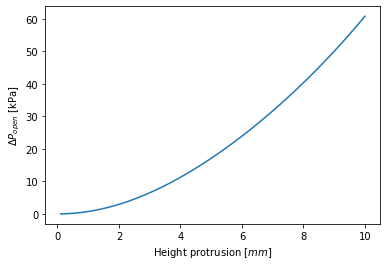

In [14]:
ID = 10e-3 # m
t_inlet = 2e-3# m
D=30e-3 #m
t_membrane=1e-3 #m

# The area has a correction factor to fit experimental data
A_membrane = (ID+2*t_inlet)*t_membrane #m2

l0 = D 
h = np.linspace(0.1,10,40)*1e-3
a= (D/2-ID/2-t_inlet) 

#Compute l1 using pythagoras, assume the length on the protrusion doesnt change
l1= np.array(2*np.sqrt(a**2+h**2)+(ID+2*t_inlet))

# Calculate strain using l1 and l0
strain = (l1-l0)/l0

#Put strain in OgdenModel to return the stress
stress_membrane = OgdenModel(strain, optim_parameters, order)*1e6 #Pa [N/m2]
F_membrane=stress_membrane*A_membrane #N

#Apply correction factor to F membrane 
"""
This is extremly wrong because the model assumed a clamped beam but where a central deflection of a uniformly loaded circular plate should be used. 
"""
constant = 8
F_membrane_correction = constant*stress_membrane*A_membrane

A_inlet = np.pi/4*ID**2 #M^2
P_open = F_membrane/A_inlet #N/m2
plt.plot(h*1000,P_open/1000)
#plt.plot(h*1000, F_membrane)
plt.xlabel('Height protrusion [$mm$]')
plt.ylabel('$\\Delta P_{open}$ [kPa]')

#print(stress_membrane/1e6)
#print(F_membrane)

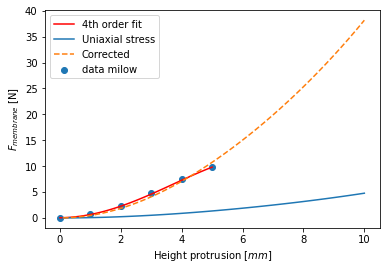

In [15]:
#Data from milo
#Values from figure 23
D_c= np.linspace(0,5,6)
F_d = [0, 0.75, 2.25, 4.8, 7.5,9.8]


#Extract coefficients for 4th order fit
#coefficients = np.polyfit(D_c,F_d,4)

#Coefficients from appendix E
coefficients = [-4.39e-3, -1.93e-2,58.53e-2, 6.01e-2, 3.58e-2]

#Create a polynomial curce for this function 
p= np.poly1d(coefficients)

D_c_fit = np.linspace(0,5,100)
F_d_fit = p(D_c_fit)

plt.scatter(D_c,F_d,label='data milow')
plt.plot(D_c_fit,F_d_fit,color='red', label='4th order fit')
plt.plot(h*1000, F_membrane,label='Uniaxial stress')
plt.plot(h*1000, F_membrane_correction,label='Corrected', linestyle ='--')
plt.xlabel('Height protrusion [$mm$]')
plt.ylabel('$F_{membrane}$ [N]')
plt.legend()

In [16]:
def compute_P_open(h, optim_parameters, order, ID, t_inlet, D, t_membrane):
    """
    Computes P_open for given height values and Ogden parameters.
    
    Parameters:
    - h: Array of height values of the protrusion
    - optim_parameters: Optimized parameters for the Ogden model
    - order: Order of the Ogden model
    - ID: internal diameter inlet
    - t_inlet: thickness of protrusion
    - D = dimater membrane 
    - t_membrane = thickness membrane
    
    Returns:
    - P_open: Array of P_open values for the given height values
    """
    
    # Derived parameters
    A_membrane =8*(ID+2*t_inlet)*t_membrane #m2
    #print('Area is '+str(A_membrane))
    l0 = D

    #l1 takes in account the lenght change by applying pythogaras on both sides and adding the lenght of the inlet 
    l1 = 2 * np.sqrt((D - (ID + 2*t_inlet) / 2)**2 + h**2) + ID + 2*t_inlet
    
    # Compute the membrane stress using the Ogden model
    stress_membrane = OgdenModel((l1-l0)/l0, optim_parameters, order)*1e6 #MPa*1e6 = N/m2
    
    # Compute the force on the membrane
    F_membrane = stress_membrane * (A_membrane) #N/m2*m2 = N
    #print('Force'+str(F_membrane))
    
    # Compute the area of the inlet
    A_inlet = (np.pi / 4) * ID**2
    
    # Compute P_open
    P_open = F_membrane / A_inlet 
    
    return P_open


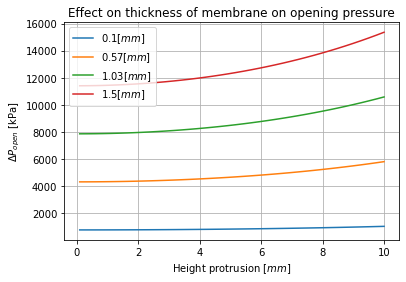

In [17]:
h_values = np.linspace(0.1, 10, 40) * 1e-3  # Vary height of inlet 
t_values= np.linspace(0.1,1.5,4)*1e-3 #vary thickness of membrane 
ID = 5e-3 # internal diameter of the inlet [m]
t_inlet = 2e-3#  thickness of the inlet [m]
D=30e-3 # Diameter membrane [m]

for thickness in t_values:
    P_open_values = compute_P_open(h_values, optim_parameters, order, ID, t_inlet, D, thickness)
    plt.plot(h_values*1000,P_open_values/1000,label=str(round(thickness*1000,2))+'[$mm$]')

#P_open_values = compute_P_open(h_values, optim_parameters, order, ID, t_inlet, D, t_values)
#plt.plot(h_values*1000,P_open_values/1000)

plt.title('Effect on thickness of membrane on opening pressure')
plt.xlabel('Height protrusion [$mm$]')
plt.ylabel('$\\Delta P_{open}$ [kPa]')
plt.legend()
plt.grid()

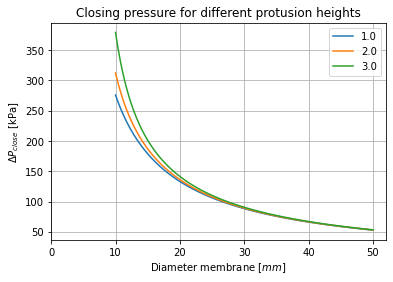

In [18]:
def compute_P_close(h, optim_parameters, order, ID, t_inlet, D, t_membrane):
    """
    Computes P_open for given height values and Ogden parameters.
    
    Parameters:
    - h: Array of height values of the protrusion
    - optim_parameters: Optimized parameters for the Ogden model
    - order: Order of the Ogden model
    - ID: internal diameter inlet
    - t_inlet: thickness of protrusion
    - D = dimater membrane 
    - t_membrane = thickness membrane
    ameter inlet, t_inlet: thickness of protrusion, D = dimater membrane, t_membrane = thickness membrane
    
    Returns:
    - P_close: Array of P_close values for the given diameters
    """
    
    # Derived parameters
    A_membrane = D * t_membrane
    #print('Area is '+str(A_membrane))
    l0 = D
    l1 = 2 * np.sqrt((D - (ID + 2*t_inlet) / 2)**2 + h**2) + ID + 2*t_inlet
    
    # Compute the membrane stress using the Ogden model
    stress_membrane = OgdenModel((l1-l0)/l0, optim_parameters, order)*1e6 #MPa = N/mm2
    
    # Compute the force on the membrane
    F_membrane = stress_membrane * (A_membrane) #N/mm2*mm2 = N

    # Compute P_close
    P_close = F_membrane *4/(np.pi*D**2)
    
    return P_close

h_values = np.linspace(1, 3, 3) * 1e-3  # Vary height of inlet 
t_membrane=1e-3# np.linspace(0.1,1.5,4)*1e-3 #vary thickness of membrane 
ID = 5e-3 # internal diameter of the inlet [m]
t_inlet = 2e-3#  thickness of the inlet [m]

# Set x-axis range 
D=np.linspace(10,50,100)*1e-3 # Diameter membrane [m]

for height in h_values:
    P_close_values = compute_P_close(height, optim_parameters, order, ID, t_inlet, D, t_membrane)
    plt.plot(D*1000,P_close_values/1000, label = str(height*1000) )

plt.title('Closing pressure for different protusion heights')
plt.xlabel('Diameter membrane [$mm$]')
plt.ylabel('$\\Delta P_{close}$ [kPa]')
plt.xlim(0,)
plt.legend()
plt.grid()


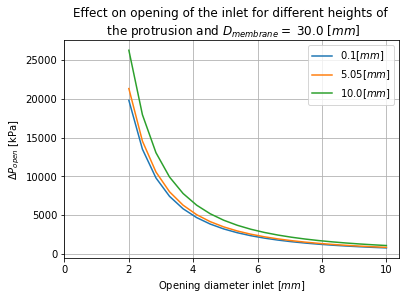

In [19]:
def compute_P_open_inlet(h, optim_parameters, order, ID, t_inlet, D, t_membrane):
    """
    Computes P_open for given height values and Ogden parameters.
    
    Parameters:
    - h: Array of height values of the protrusion
    - optim_parameters: Optimized parameters for the Ogden model
    - order: Order of the Ogden model
    - ID: internal diameter inlet
    - t_inlet: thickness of protrusion
    - D = dimater membrane 
    - t_membrane = thickness membrane
    
    Returns:
    - P_open: Array of P_open values for the given height values
    """
    
    # Derived parameters
    A_membrane = D * t_membrane
    
    
    l0 = D
    l1 = 2 * np.sqrt((D - (ID + 2*t_inlet) / 2)**2 + h**2) + ID + 2*t_inlet
    #print(l1)
    
    # Compute the membrane stress using the Ogden model
    stress_membrane = OgdenModel((l1-l0)/l0, optim_parameters, order)*1e6 #MPa = N/mm2
    #print(stress_membrane)

    # Compute the force on the membrane
    F_membrane = stress_membrane * (A_membrane) #N/mm2*mm2 = N
    #print('Force'+str(F_membrane))
    
    # Compute the area of the inlet
    A_inlet = (np.pi / 4) * ID**2
    
    # Compute P_open
    P_open = F_membrane / A_inlet 
    
    return P_open

# Fix parameters 
t_values= 1e-3 #vary thickness of membrane 
t_inlet = 2e-3#  thickness of the inlet [m]
D=30e-3 # Diameter membrane [m]

#Set x axis range
ID = np.linspace(2,10,20)*1e-3 # internal diameter of the inlet [m]

#Define different lines in plot 
h_values = np.linspace(0.1, 10, 3) * 1e-3  # Vary height of inlet 

for height in h_values:
    P_open_values = compute_P_open_inlet(height, optim_parameters, order, ID, t_inlet, D, t_values)
    plt.plot(ID*1000,P_open_values/1000,label=str(height*1000)+'[$mm$]')


plt.title('Effect on opening of the inlet for different heights of \n the protrusion and $D_{membrane} =$ '+str(D*1000)+' [$mm$]')
plt.xlabel('Opening diameter inlet [$mm$]')
plt.ylabel('$\\Delta P_{open}$ [kPa]')
plt.xlim(0,)
#plt.ylim(0,100)
plt.legend()
plt.grid()
plt.show()




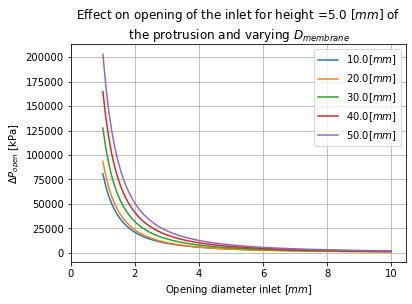

In [20]:
#Fix the height of the protrusion
height = 5e-3

#Set x range
ID = np.linspace(1,10,100)*1e-3

#Define different lines in plot
D_vary = np.linspace(10,50,5)*1e-3

for D_var in D_vary:
    P_open_inlet_values = compute_P_open_inlet(height, optim_parameters, order, ID, t_inlet, D_var, thickness)
    plt.plot(ID*1000,P_open_inlet_values/1000,label=str(round(D_var*1000,0))+'[$mm$]')


plt.title('Effect on opening of the inlet for height ='+str(height*1000)+' [$mm$] of \n the protrusion and varying $D_{membrane}$ ')
plt.xlabel('Opening diameter inlet [$mm$]')
plt.ylabel('$\\Delta P_{open}$ [kPa]')
plt.xlim(0,)
#plt.ylim(0,1000)
plt.legend()
plt.grid()
